In [1]:
from pettingzoo.classic import connect_four_v3

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output
from utils import * 
from collections import defaultdict
import random as rd
import tqdm



# Using the PettingZoo environment

This notebook provides smalls chunks of code to get you started with the Connect4 project. You do not have to use this code in you final file, but you can if you wish to. 

In [3]:
env = connect_four_v3.env(render_mode="rgb_array")

env.reset()

# The main difference with the standard gym api is the way the environment is queried. The `step` method return `None`. To get the data on the environment, use the `last` method
state, reward, terminated, truncated, info = env.last()

# state is a dictionary with two keys: observation and action_mask
print(
    state["observation"].shape
)  # Observation is a numpy array with three coordinates, indicating the positions of the pieces of of player 0 and 1 on the the board
print(state["observation"][:, :, 0])  # Where the pieces of player 0 are
print(state["observation"][:, :, 1])  # Where the pieces of player 1 are

print(state["action_mask"])  # an array showing whether the actions are legal or nots


(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


In [4]:
env.reset()
env.step(0)

state, reward, terminated, truncated, info = env.last()

print(
    state["observation"].shape
) 
print(state["observation"][:, :, 0])  
print(state["observation"][:, :, 1])  

print(state["action_mask"])

(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


# Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [5]:
class RandomPlayer:
    def __init__(self, rng=None):
        if rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = rng

        self.name = "Random Player"

    def get_action(self, obs_mask, epsilon=None):
        return self.random_choice_with_mask(np.arange(7), obs_mask["action_mask"])

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())


In [6]:
class PlayLeftmostLegal:
    def __init__(self):
        self.name = "Left Player"

    def get_action(self, obs_mask, epsilon=None):
        for i, legal in enumerate(obs_mask["action_mask"]):
            if legal:
                return i
        return None


# Running a game


The following function runs a full game between the two agents. 

In [7]:
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        for i, agent in enumerate([agent0, agent1]):
            action = agent.get_action(obs, epsilon=0)
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, terminated, _, _ = env.last()
            done = terminated
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won")
                    print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                return i

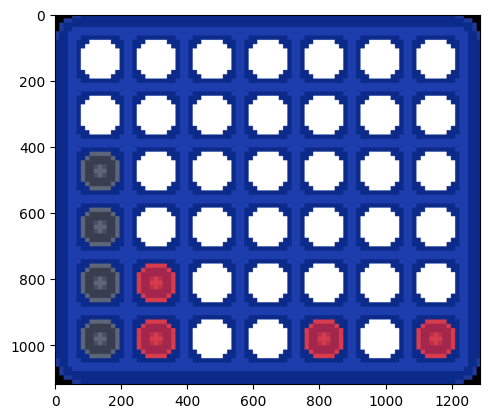

Player 1: Left Player won
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [ 1 -1  0  0  0  0  0]
 [ 1 -1  0  0 -1  0 -1]]


1

In [8]:
agent0 = RandomPlayer()
agent1 = PlayLeftmostLegal()

play_game(env, agent0, agent1, display=True)

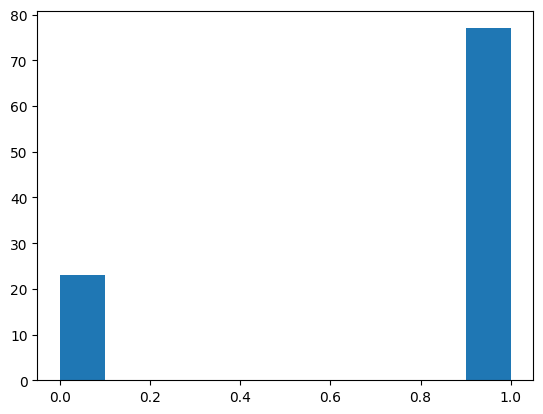

In [9]:
plt.hist([play_game(env, agent0, agent1, display=False) for _ in range(100)])
plt.show()

# Emulating a Gym environment

If we fix the opposite policy, the game from the point of view of the agent is equivalent to a Gym environment. The following class implements this simulation. Then any algorithm that would work in a gym environment with the same observations will work here. 

Note that we implemented the possibility to be the first or the second player. 

In [10]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_action(obs)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_action(obs)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

# Evaluating an agent against a fixed policy: 

Using the environment above, we can evaluate the agent against this fixed policy. 

In [11]:
def eval_against_policy(env, agent, policy, N_episodes=10, first_player=True, display = False, pourcentage_display = 10):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    results = []
    for i in range(N_episodes):
        if display and i % round(N_episodes/pourcentage_display) == 0 :
            print(i, "sur", N_episodes)
        done = False
        eval_env.reset()
        obs, _, _, _, _ = eval_env.last()
        while not done:
            action = agent.get_action(obs, epsilon=0)
            eval_env.step(action)
            obs, reward, done, _, _ = eval_env.last()
        results.append(reward)
    return results

We can see that if both players play randomly, there is a small but significant advantage to the first player. 

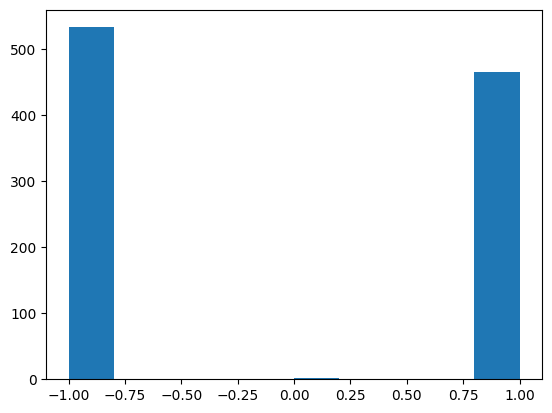

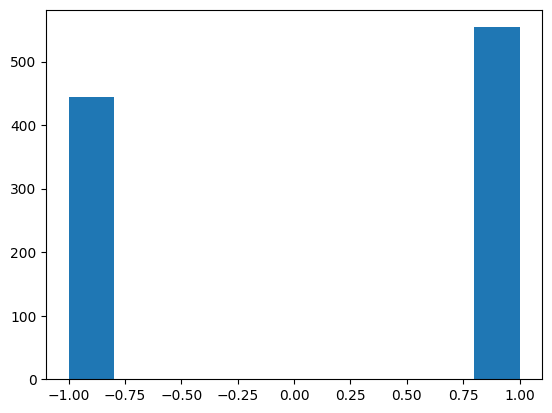

In [12]:
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=True))
plt.show()

# Your turn 

Try to build a decent agent. Be creative! You can try any idea that you have: the grade is not about performance of the agent, but more about illustrating phenomena happening in Reinforcement Learning for turn-based games. It's okay to 'help' the agent in any way, as long as it follows the ideas of RL (i.e., as long as there is some learning involved).




In [13]:
class MCConnect4Controller: 
    """
        Monte-Carlo control
    """
    def __init__(self,
                 gamma=0.99, 
                 eps_init=.5, 
                 eps_min=1e-5,
                 eps_step=1e-3,
                 episodes_between_greedyfication=500,
                 name='MC Controller'
                ):
        
        self.action_space = list(range(7))
        self.observation_space = (list(range(6)), list(range(7)), list(range(2)))
        self.gamma = gamma
        self.name = name

        self.eps = eps_init
        self.eps_min = eps_min
        self.eps_step = eps_step

        self.episodes_between_greedyfication = episodes_between_greedyfication
        self.episode_counter = 0
        
        self.reset()

    def eps_greedy(self, obs, action_mask, eps=None):
        if eps is None: 
            eps = self.eps

        if sum(action_mask) == 0:
            # print(action_mask)
            print("coucou")
            return None

        # Return a greedy action wrt the action values estimates.

        if np.random.random() < self.eps: 
            masked_arr = np.ma.masked_array(self.action_space, mask=1 - action_mask).compressed()
            return np.random.choice(masked_arr)
        else:
            actions = self.q_values[obs]
            masked_arr = self.put_values_to_zero_mask_array(actions, action_mask)
            return np.random.choice(np.flatnonzero(masked_arr == np.max(masked_arr))) # argmax with random tie-breaking
            #return np.argmax(b)

    def put_values_to_zero_mask_array(self, arr, mask):
        masked_arr = []
        for masked, value in zip(mask, arr) :
            if masked :
                masked_arr.append(value)
            else : masked_arr.append(np.NINF)
        return masked_arr
        
    def get_action(self, state, epsilon=None): 
        obs = totuple(state["observation"])
        action_mask = state["action_mask"]
        return self.eps_greedy(obs, action_mask)
        
    def update(self, state, action, reward, terminated, next_obs):
        self.current_episode_rewards.append(reward)
        obs = totuple(state["observation"])
        self.current_episode_obs.append((obs, action))
        
        if terminated:
            self._end_of_episode_update()

    def _end_of_episode_update(self):
        current_episode_returns = rewardseq_to_returns(self.current_episode_rewards, self.gamma)
        seen = []
        for i, (state, action) in enumerate(self.current_episode_obs): 
            if (state, action) not in seen: 
                seen.append((state, action))
                return_value = current_episode_returns[i]
                
                n = self.number_of_values_in_estimate[state, action]
                self.values_estimates[state][action] = n / (n + 1) * self.values_estimates[state][action] + 1 / (n+1) * return_value
                self.number_of_values_in_estimate[state, action] += 1
                            
        self.current_episode_rewards = []
        self.current_episode_obs = []

        self.episode_counter += 1 
        
        if self.episode_counter % self.episodes_between_greedyfication == 0:
            new_q_values = defaultdict(lambda: np.zeros(len(self.action_space)))
            for state in self.values_estimates: 
                new_q_values[state] = self.values_estimates[state]
            self.reset(q_values=new_q_values)
            self.epsilon_decay()
    
    def epsilon_decay(self):
        self.eps = max(self.eps - self.eps_step, self.eps_min)
            
    def reset(self, q_values=None):
        self.current_episode_rewards = []
        self.current_episode_obs = []

        if q_values is None:
            self.q_values = defaultdict(lambda: np.zeros(len(self.action_space)))
        else: 
            self.q_values = q_values

        self.values_estimates = defaultdict(lambda: np.zeros(len(self.action_space)))
        self.number_of_values_in_estimate = defaultdict(lambda : 0)

In [14]:
def run_N_episodes(env, agent, policy, N_episodes=10, first_player=True, display = False):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    for i in tqdm.tqdm(range(N_episodes)):

        if display and (i+1) % agent.episodes_between_greedyfication == 0 :
            print(i+1, "sur", N_episodes)
            
        done = False
        eval_env.reset()
        state, reward, terminated, truncated, _ = eval_env.last()
        while not done:
            action = agent.get_action(state)
            eval_env.step(action)
            next_state, reward, terminated, truncated, _ = eval_env.last()
            agent.update(state, action, reward, terminated, next_state)
            done = terminated or truncated

            state = next_state
    return eval_env, agent

# Against Left Player

100%|██████████| 10000/10000 [00:39<00:00, 252.91it/s]


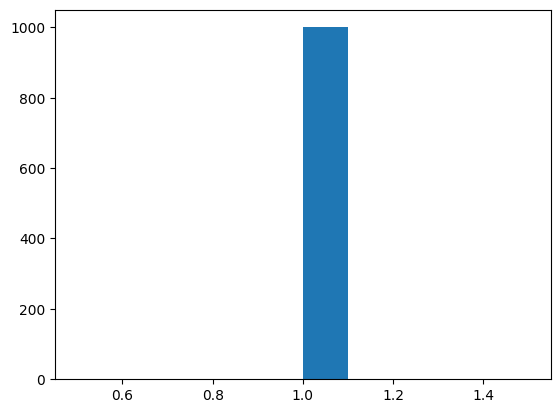

Contre LeftPlayer
Nombre de victoires : 1000
Nombre de matchs nuls : 0
Nombre de défaites : 0


In [15]:
gamma = .999
N_episodes = 10_000

episodes_between_greedyfication = 500

eps_init = .1
eps_step= eps_init * episodes_between_greedyfication / N_episodes

mc_agent = MCConnect4Controller(eps_init=eps_init, eps_step=eps_step, gamma=gamma, episodes_between_greedyfication=episodes_between_greedyfication)

# Notre agent joue en premier.

_, mc_agent = run_N_episodes(env, mc_agent, PlayLeftmostLegal(), N_episodes=N_episodes, first_player=True)

results = eval_against_policy(env, mc_agent, PlayLeftmostLegal(), N_episodes=1000, first_player=True)
plt.hist(results)
plt.show()

print("Contre LeftPlayer")
print("Nombre de victoires :", results.count(1))
print("Nombre de matchs nuls :", results.count(0))
print("Nombre de défaites :", results.count(-1))

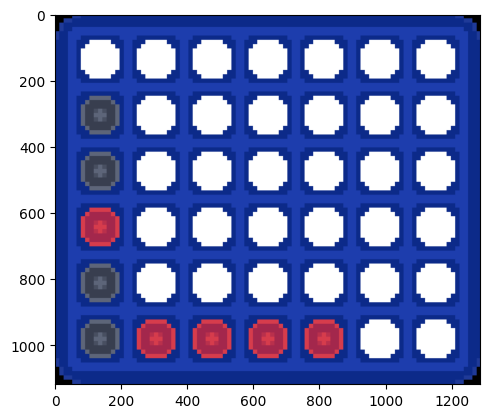

Player 0: MC Controller won
[[ 0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [-1  1  1  1  1  0  0]]


0

In [16]:
play_game(env, mc_agent, PlayLeftmostLegal(), display=True)

100%|██████████| 10000/10000 [00:47<00:00, 209.74it/s]


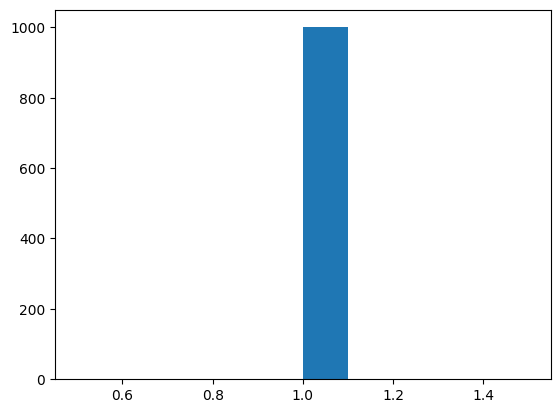

Contre LeftPlayer
Nombre de victoires : 1000
Nombre de matchs nuls : 0
Nombre de défaites : 0


In [17]:
# Notre agent joue en deuxième

mc_agent = MCConnect4Controller(eps_init=eps_init, eps_step=eps_step, gamma=gamma, episodes_between_greedyfication=episodes_between_greedyfication)

_, mc_agent = run_N_episodes(env, mc_agent, PlayLeftmostLegal(), N_episodes=N_episodes, first_player=False)

results = eval_against_policy(env, mc_agent, PlayLeftmostLegal(), N_episodes=1000, first_player=False)
plt.hist(results)
plt.show()

print("Contre LeftPlayer")
print("Nombre de victoires :", results.count(1))
print("Nombre de matchs nuls :", results.count(0))
print("Nombre de défaites :", results.count(-1))


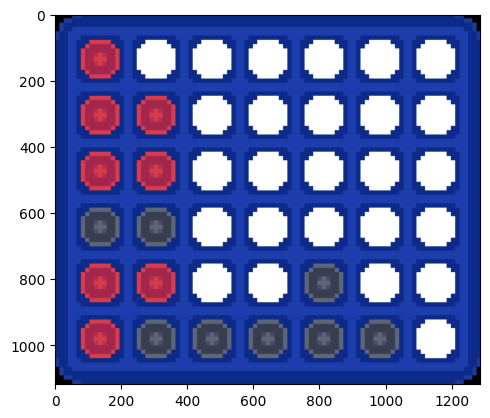

Player 1: MC Controller won
[[-1  0  0  0  0  0  0]
 [-1 -1  0  0  0  0  0]
 [-1 -1  0  0  0  0  0]
 [ 1  1  0  0  0  0  0]
 [-1 -1  0  0  1  0  0]
 [-1  1  1  1  1  1  0]]


1

In [18]:
play_game(env, PlayLeftmostLegal(), mc_agent, display=True)

We can see than the MonteCarlo controlled agent wins 100% of the time against a player with a precise strategy. In my opinion, this is because the agent learnt how to counter that strategy, but didn't learnt how to win however. Thus, against Left player, the MC agent counters the strategy then wins while playing randomly.

# Against Random Player

Let's see how the MC agent is doing against a random player :

100%|██████████| 100000/100000 [11:06<00:00, 149.95it/s]


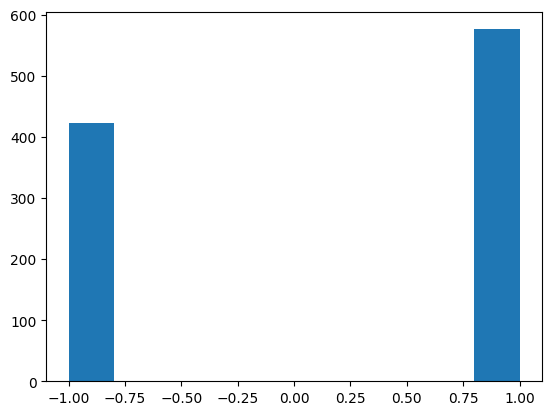

Contre RandomPlayer
Nombre de victoires : 576
Nombre de matchs nuls : 1
Nombre de défaites : 423


In [19]:
gamma = .9999
N_episodes = 100_000 

episodes_between_greedyfication = 500

eps_init = .2
eps_step= eps_init * episodes_between_greedyfication / N_episodes

agent = MCConnect4Controller(eps_init=eps_init, eps_step=eps_step, gamma=gamma, episodes_between_greedyfication=episodes_between_greedyfication)

# Notre agent joue en premier.

_, agent = run_N_episodes(env, agent, RandomPlayer(), N_episodes=N_episodes, first_player=True)

results = eval_against_policy(env, agent, RandomPlayer(), N_episodes=1000, first_player=True)
plt.hist(results)
plt.show()

print("Contre RandomPlayer")
print("Nombre de victoires :", results.count(1))
print("Nombre de matchs nuls :", results.count(0))
print("Nombre de défaites :", results.count(-1))

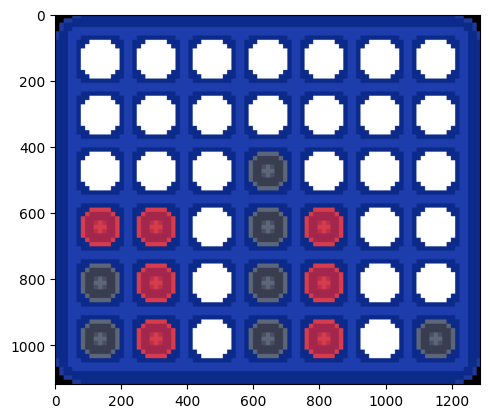

Player 1: Random Player won
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [-1 -1  0  1 -1  0  0]
 [ 1 -1  0  1 -1  0  0]
 [ 1 -1  0  1 -1  0  1]]


1

In [20]:
play_game(env, mc_agent, RandomPlayer(), display=True)

100%|██████████| 100000/100000 [07:09<00:00, 232.97it/s]


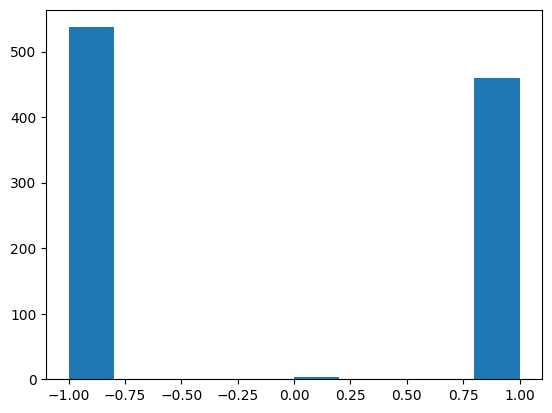

Contre RandomPlayer
Nombre de victoires : 460
Nombre de matchs nuls : 3
Nombre de défaites : 537


In [21]:
mc_agent = MCConnect4Controller(eps_init=eps_init, eps_step=eps_step, gamma=gamma, episodes_between_greedyfication=episodes_between_greedyfication)

_, mc_agent = run_N_episodes(env, mc_agent, RandomPlayer(), N_episodes=N_episodes, first_player=False)

results = eval_against_policy(env, mc_agent, RandomPlayer(), N_episodes=1000, first_player=False)
plt.hist(results)
plt.show()

print("Contre RandomPlayer")
print("Nombre de victoires :", results.count(1))
print("Nombre de matchs nuls :", results.count(0))
print("Nombre de défaites :", results.count(-1))

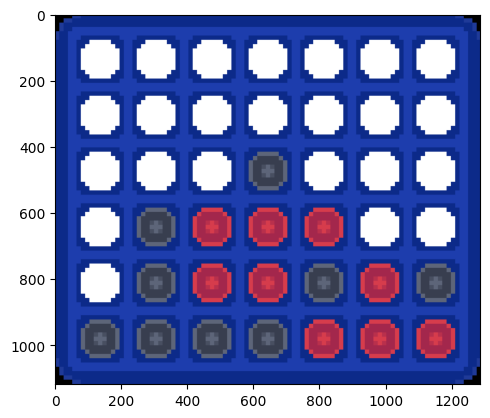

Player 1: MC Controller won
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  1 -1 -1 -1  0  0]
 [ 0  1 -1 -1  1 -1  1]
 [ 1  1  1  1 -1 -1 -1]]


1

In [22]:
play_game(env, RandomPlayer(), mc_agent, display=True)

Here, the random player has no inherent strategy, no policy. Thus, the MC method is not really adapted, being a on-policy method : our agent has to learn the whole space of states. And the results show that : the MC agent is no doing any better than a RandomPlayer playing against a RandomPlayer.

Maybe with more episodes the MC agent would do better.